In [1]:
import tensorflow as tf
import math
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
Batch_size = 32
Image_size = 256
Channels = 3
EPOCHS =20

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(Image_size, Image_size),
    batch_size=(Batch_size))

Found 20638 files belonging to 15 classes.


In [5]:
class_names=dataset.class_names
n_classes=len(class_names)
class_names


['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
len(dataset)

645

In [7]:
# Verifying the shape of data
for image_batch, label_batch in dataset.take(3):
    print(image_batch.shape)
    print(label_batch.shape)

(32, 256, 256, 3)
(32,)
(32, 256, 256, 3)
(32,)
(32, 256, 256, 3)
(32,)


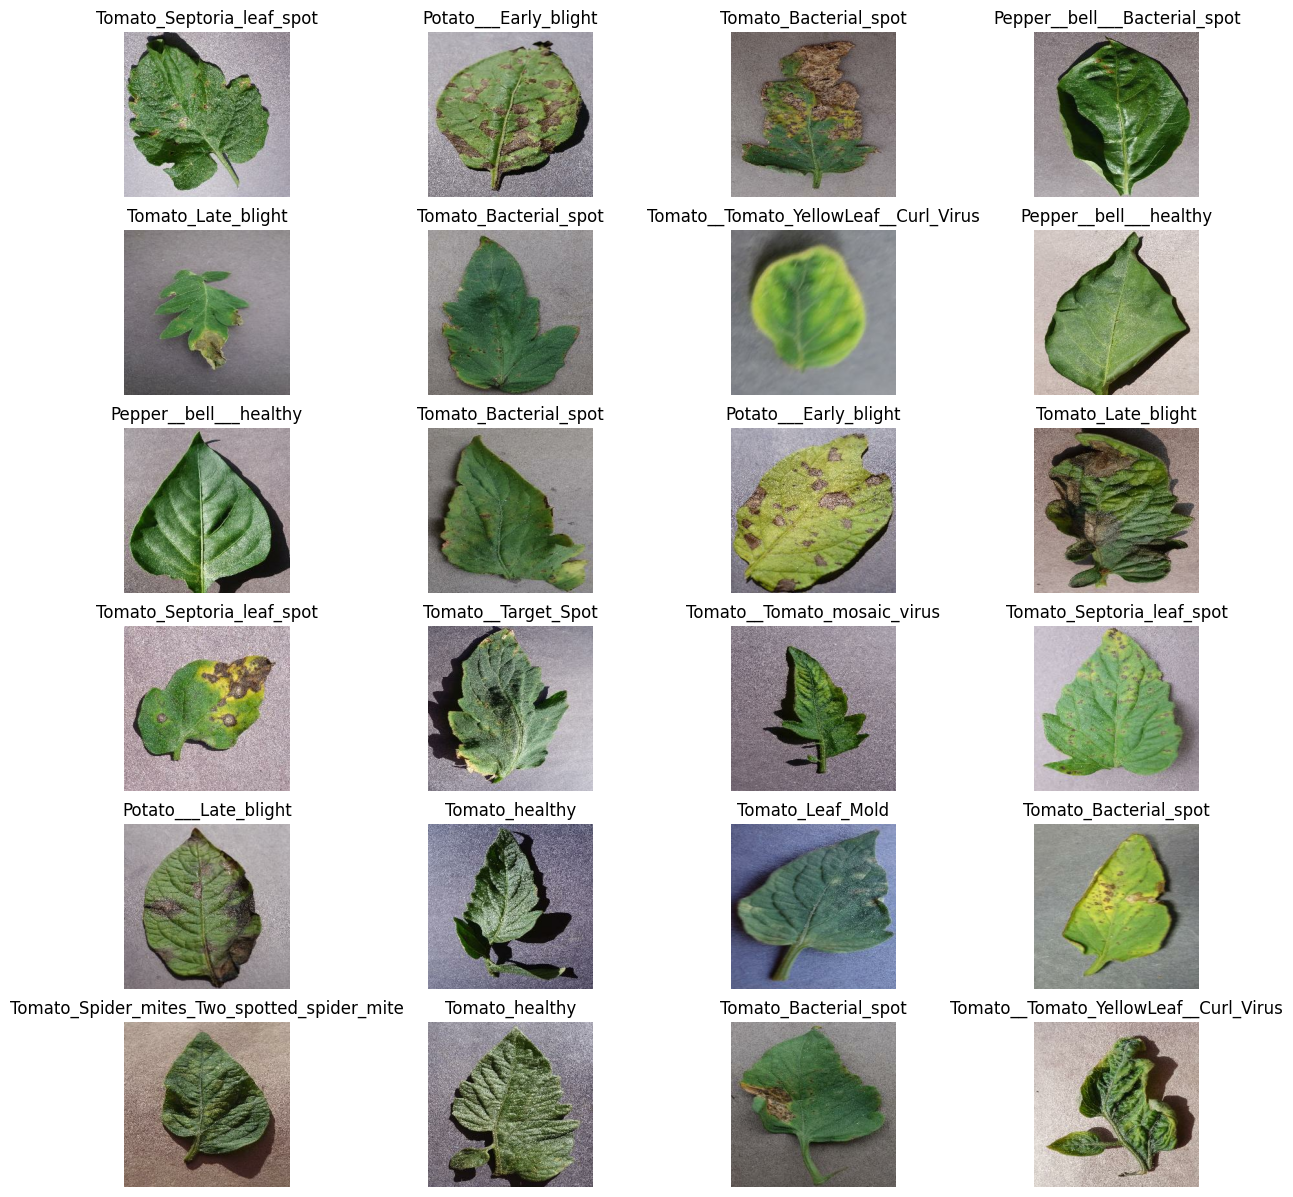

In [8]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(24):
        ax=plt.subplot(6,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off") 

In [9]:
# function to partition dataset in training, cross-validation and test set
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, reshuffle_each_iteration=False, seed=12)
        # reshuffle_each_iteration=False is done to have separate training, validation and test sets
        
    train_size=math.floor(train_split*ds_size)
    val_size=math.floor(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [11]:
len(train_ds), len(val_ds), len(test_ds)

(516, 64, 65)

In [12]:
# Caching and prefetching in order to optimise the hardware usage
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
def model_building(model_name, INPUT_SHAPE=[Image_size, Image_size, Channels]):
    """Function to build model using transfer learning"""
    
    print('Model Initialization started')
    base_model = model_name(include_top=False, weights='imagenet', input_shape=[Image_size, Image_size, Channels])
    
    for layer in base_model.layers:
        layer.trainable = False  # Freezing the middle layers
    print('Model Initialization finished')
    
    #model creation
    print('Model creation started')
    inp_model = base_model.output
    
    # Adding layers at the top
    x = layers.GlobalAveragePooling2D()(inp_model)
    x = layers.Dense(256, activation = 'relu')(x)
    x = layers.Dense(n_classes, activation = 'sigmoid')(x)
    
    model = models.Model(inputs = base_model.input, outputs = x)
    
    #model compilation
    model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    #model training
    history = model.fit(train_ds, validation_data=val_ds, verbose=1,batch_size=Batch_size, epochs=EPOCHS)
    
    print('Model Building Finished')
    
    return model, history

In [14]:
def evaluation_plot(hist):
    """Function to visualise model training process"""
    sns.set_style('whitegrid')
    
    plt.figure(figsize=(10, 8))
    plt.plot(hist['loss'], label = 'loss')
    plt.plot(hist['accuracy'], label = 'accuracy')
    plt.plot(hist['val_loss'], label = 'val_loss')
    plt.plot(hist['val_accuracy'], label = 'val_accuracy')
    plt.legend()
    plt.title('Model Evaluation')
    plt.show()

In [15]:
vgg16_model, vgg16_hist = model_building(VGG16)


Model Initialization started
Model Initialization finished
Model creation started
Epoch 1/20
516/516 [==============================] - 306s 519ms/step - loss: 0.5971 - accuracy: 0.8207 - val_loss: 0.2883 - val_accuracy: 0.9033
Epoch 2/20
516/516 [==============================] - 238s 461ms/step - loss: 0.2535 - accuracy: 0.9183 - val_loss: 0.1575 - val_accuracy: 0.9492
Epoch 3/20
516/516 [==============================] - 208s 403ms/step - loss: 0.1779 - accuracy: 0.9389 - val_loss: 0.1674 - val_accuracy: 0.9419
Epoch 4/20
516/516 [==============================] - 212s 411ms/step - loss: 0.1393 - accuracy: 0.9536 - val_loss: 0.1625 - val_accuracy: 0.9443
Epoch 5/20
516/516 [==============================] - 209s 406ms/step - loss: 0.1132 - accuracy: 0.9610 - val_loss: 0.1568 - val_accuracy: 0.9482
Epoch 6/20
516/516 [==============================] - 221s 428ms/step - loss: 0.0872 - accuracy: 0.9683 - val_loss: 0.0908 - val_accuracy: 0.9736
Epoch 7/20
516/516 [======================

In [16]:
scores = vgg16_model.evaluate(test_ds)

65/65 [==============================] - 58s 334ms/step - loss: 0.0862 - accuracy: 0.9798


In [17]:
tf.keras.models.save_model(vgg16_model, "TransferLearning.Model")

INFO:tensorflow:Assets written to: TransferLearning.Model\assets


In [18]:
scores

[0.08618032932281494, 0.9798076748847961]

In [19]:
vgg16_hist

In [20]:
vgg16_hist.params

{'verbose': 1, 'epochs': 20, 'steps': 516}

In [21]:
acc = vgg16_hist.history['accuracy']
val_acc = vgg16_hist.history['val_accuracy']

loss = vgg16_hist.history['loss']
val_loss = vgg16_hist.history['val_loss']

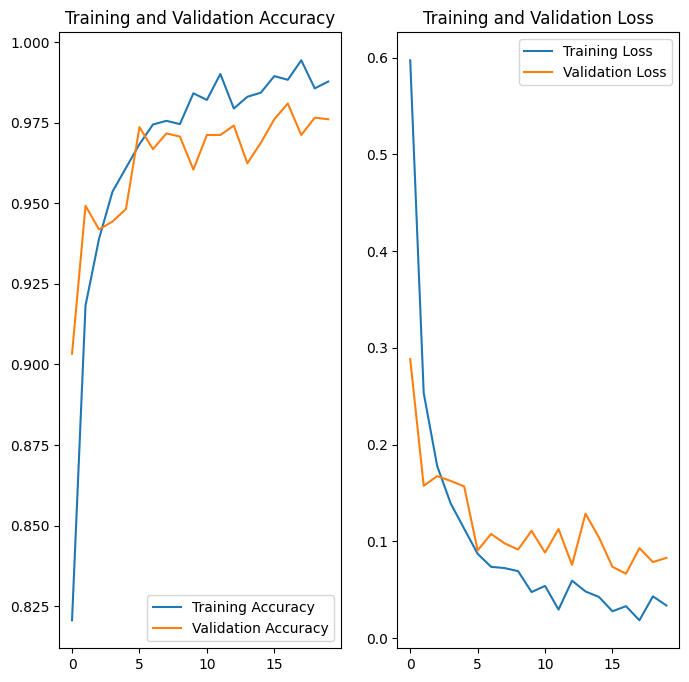

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato_Late_blight
predicted label: Tomato_Late_blight


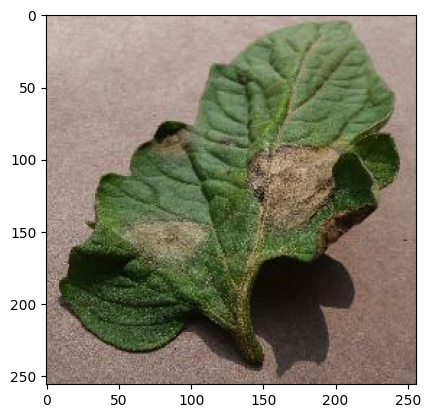

In [23]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = vgg16_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [24]:
def predict(vgg16_model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = vgg16_model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

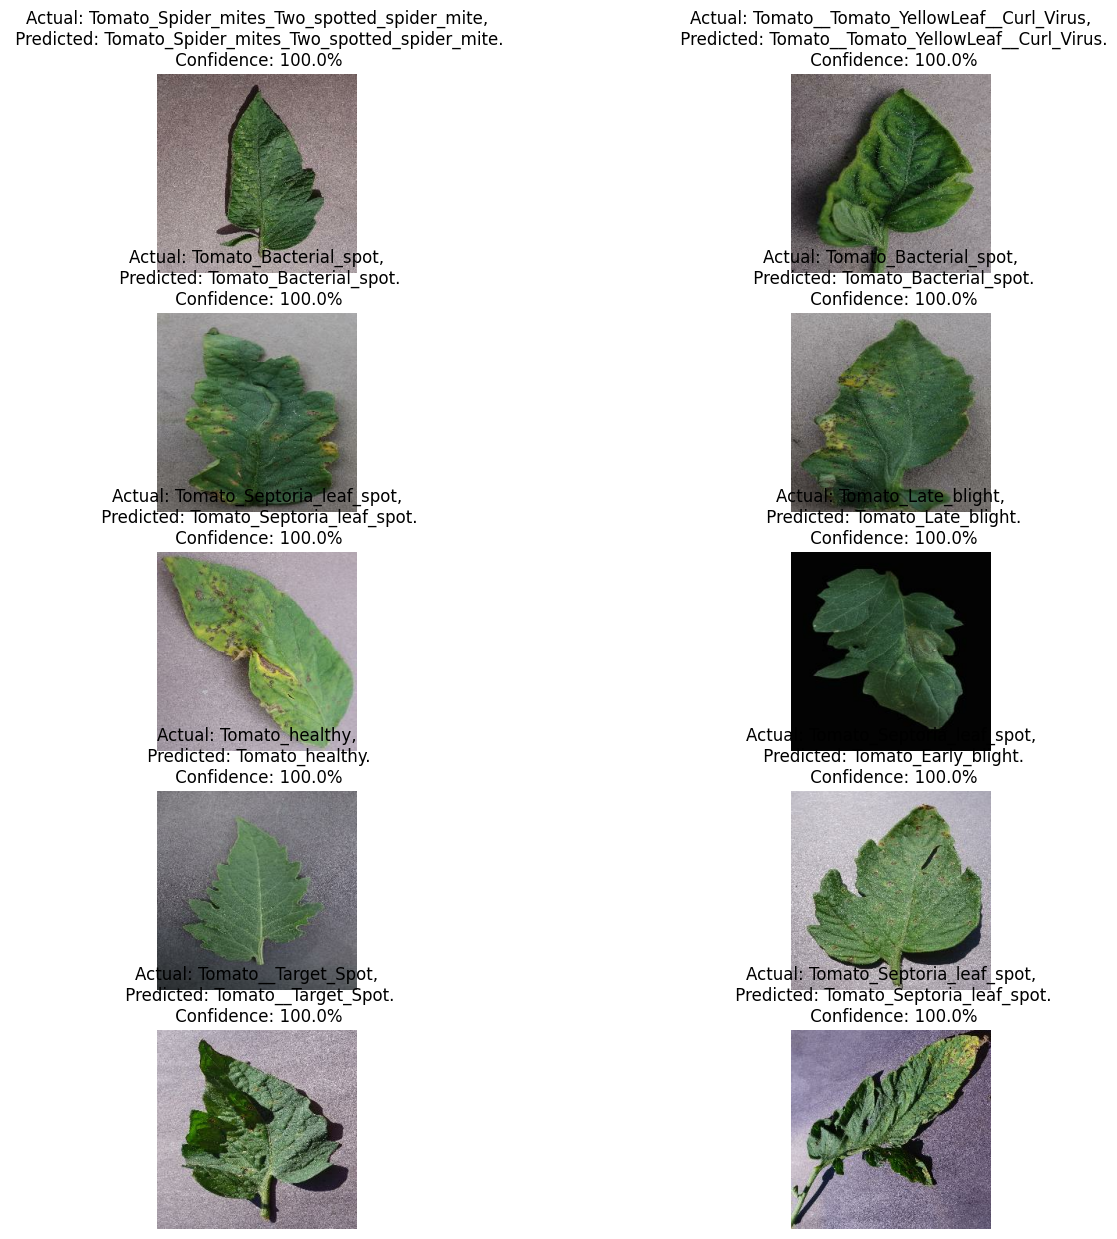

In [25]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(10):
        ax = plt.subplot(5, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(vgg16_model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")